<a href="https://colab.research.google.com/github/Baka-14/SaleForecasting/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error,mean_squared_log_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from category_encoders.ordinal import OrdinalEncoder

from sklearn.metrics import mean_squared_error,mean_squared_log_error
from sklearn.model_selection import train_test_split

from category_encoders.ordinal import OrdinalEncoder
import matplotlib.pyplot as plt


In [157]:
train=pd.read_csv('Traindata.csv')
test=pd.read_csv('DataSetRetail.csv')
submission=pd.read_csv('submission format.csv')

In [158]:
train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17-01-2011,8091,216418,99.0375,111.8625,0,0,20
1,2,17-01-2011,8091,216419,99.0375,99.0375,0,0,28
2,3,17-01-2011,8091,216425,133.9500,133.9500,0,0,19
3,4,17-01-2011,8091,216233,133.9500,133.9500,0,0,44
4,5,17-01-2011,8091,217390,141.0750,141.0750,0,0,52


In [159]:
len(train.columns)

9

In [160]:
train.describe()

,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
count,150150.000000,150150.000000,150150.000000,150149.000000,150150.000000,150150.000000,150150.000000,150150.000000
mean,106271.555504,9199.422511,254761.132468,206.626751,219.425927,0.095611,0.133200,51.674206
std,61386.037861,615.591445,85547.306447,103.308516,110.961712,0.294058,0.339792,60.207904
min,1.000000,8023.000000,216233.000000,41.325000,61.275000,0.000000,0.000000,1.000000
25%,53111.250000,8562.000000,217217.000000,130.387500,133.237500,0.000000,0.000000,20.000000
50%,106226.500000,9371.000000,222087.000000,198.075000,205.912500,0.000000,0.000000,35.000000
75%,159452.750000,9731.000000,245338.000000,233.700000,234.412500,0.000000,0.000000,62.000000
max,212644.000000,9984.000000,679023.000000,562.162500,562.162500,1.000000,1.000000,2876.000000


In [161]:
train.isna().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [162]:

train.total_price=train.total_price.fillna(206.626751)



In [163]:
print(train.isna().sum().sum())
print(test.isna().sum().sum())

0
0


In [164]:
train.columns

Index(['record_ID', 'week', 'store_id', 'sku_id', 'total_price', 'base_price',
       'is_featured_sku', 'is_display_sku', 'units_sold'],
      dtype='object')

In [165]:
def gen_average_units(train,test,col,name):
    temp=train.groupby(col)['units_sold'].mean().reset_index().rename(columns={'units_sold':name})
    train=pd.merge(train,temp,how='left',on=col)
    test=pd.merge(test,temp,how='left',on=col)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test


In [166]:
def gen_average_price(train,test,col,price='base_price',name='name'):
    temp=train.groupby(col)[price].mean().reset_index().rename(columns={price:name})
    train=pd.merge(train,temp,how='left',on=col)
    test=pd.merge(test,temp,how='left',on=col)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test

In [167]:
train,test = gen_average_units(train,test,col=['sku_id','store_id'],name='count_sku_store_id') #Genearting average units sold per 'sku-id & store-id'
train,test = gen_average_units(train,test,col=['store_id'],name='count_store_id') #Genearting average units sold per 'store-id'
train,test = gen_average_units(train,test,col=['sku_id'],name='count_sku_id') #Genearting average units sold per 'sku-id'


In [168]:
train,test = gen_average_price(train,test,col=['sku_id','store_id'],price='base_price',name='price_sku_store') #Genearting average base price per 'sku-id & store-id'
train,test = gen_average_price(train,test,col=['sku_id','store_id'],price='total_price',name='price_to_sku_store') #Genearting average total price per 'sku-id & store-id'
train,test = gen_average_price(train,test,col=['store_id'],price='base_price',name='price_store_id') #Genearting average base price per 'store-id'
train,test = gen_average_price(train,test,col=['sku_id'],price='base_price',name='price_sku_id') #Genearting average base price per 'sku-id'
train,test = gen_average_price(train,test,col=['store_id'],price='total_price',name='price_to_store_id') #Genearting average total price per 'store-id'
train,test = gen_average_price(train,test,col=['sku_id'],price='total_price',name='price_to_sku_id')

In [169]:
#Converting week feature
le = OrdinalEncoder()
train['week_1']=le.fit_transform(train['week'])
le = OrdinalEncoder()
test['week_1']=le.fit_transform(test['week'])+130

#Creating week number feature
train['week_num']=train.week_1%52
test['week_num']=test.week_1%52

train['week_num1']=train.week_1%4
test['week_num1']=test.week_1%4


#Creating feature: percent difference between base price and checkout price.
train['price_diff_percent'] = (train['base_price'] - train['total_price']) / train['base_price']
test['price_diff_percent'] = (test['base_price'] - test['total_price']) / test['base_price']

In [170]:
train.tail()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,count_sku_store_id,...,price_sku_store,price_to_sku_store,price_store_id,price_sku_id,price_to_store_id,price_to_sku_id,week_1,week_num,week_num1,price_diff_percent
150145,212638,09-07-2013,9984,223245,235.8375,235.8375,0,0,38,61.384615,...,221.423077,207.693750,197.030107,214.878438,186.580537,203.073612,130,26,2,0.000000
150146,212639,09-07-2013,9984,223153,235.8375,235.8375,0,0,30,53.023077,...,226.465385,211.892019,197.030107,220.461485,186.580537,206.303241,130,26,2,0.000000
150147,212642,09-07-2013,9984,245338,357.6750,483.7875,1,1,31,21.553846,...,467.838462,425.066538,197.030107,476.750449,186.580537,432.734649,130,26,2,0.260677
150148,212643,09-07-2013,9984,547934,141.7875,191.6625,0,1,12,14.100000,...,172.644231,162.954231,197.030107,174.616247,186.580537,166.385369,130,26,2,0.260223
150149,212644,09-07-2013,9984,679023,234.4125,234.4125,0,0,15,13.861538,...,208.154135,197.033654,197.030107,209.117532,186.580537,198.309455,130,26,2,0.000000


In [171]:
len(train.columns)

22

In [172]:
test.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,count_sku_store_id,count_store_id,...,price_sku_store,price_to_sku_store,price_store_id,price_sku_id,price_to_store_id,price_to_sku_id,week_1,week_num,week_num1,price_diff_percent
0,212645,16-07-2013,8091,216418,108.3000,108.3000,0,0,26.376923,32.805983,...,105.800769,102.117692,181.312372,94.688268,172.272756,91.982702,131,27,3,0.0
1,212646,16-07-2013,8091,216419,109.0125,109.0125,0,0,28.307692,32.805983,...,105.839135,102.473942,181.312372,94.908763,172.272756,92.349162,131,27,3,0.0
2,212647,16-07-2013,8091,216425,133.9500,133.9500,0,0,25.669231,32.805983,...,131.204135,126.671538,181.312372,128.285210,172.272756,125.156355,131,27,3,0.0
3,212648,16-07-2013,8091,216233,133.9500,133.9500,0,0,29.107692,32.805983,...,129.916154,126.167308,181.312372,128.101871,172.272756,124.942208,131,27,3,0.0
4,212649,16-07-2013,8091,217390,176.7000,176.7000,0,0,29.469231,32.805983,...,164.439519,152.968269,181.312372,158.990538,172.272756,150.867334,131,27,3,0.0


In [173]:
X=train[list(set(train.columns)-set(['record_ID','units_sold','week']))]
Y= np.log1p(train['units_sold'])
X_test=test[list(set(test.columns)-set(['record_ID','week']))]

In [174]:
X['sku_id'] = X['sku_id'].astype('category')
X['store_id'] = X['store_id'].astype('category')

<ipython-input-174-e48847a22291>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sku_id'] = X['sku_id'].astype('category')
<ipython-input-174-e48847a22291>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['store_id'] = X['store_id'].astype('category')


In [175]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150150 entries, 0 to 150149
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   total_price         150150 non-null  float64 
 1   price_to_store_id   150150 non-null  float64 
 2   sku_id              150150 non-null  category
 3   is_display_sku      150150 non-null  int64   
 4   count_store_id      150150 non-null  float64 
 5   price_to_sku_id     150150 non-null  float64 
 6   week_num1           150150 non-null  int64   
 7   is_featured_sku     150150 non-null  int64   
 8   base_price          150150 non-null  float64 
 9   week_1              150150 non-null  int64   
 10  store_id            150150 non-null  category
 11  price_sku_store     150150 non-null  float64 
 12  price_diff_percent  150150 non-null  float64 
 13  count_sku_store_id  150150 non-null  float64 
 14  count_sku_id        150150 non-null  float64 
 15  price_to_sku_stor

In [176]:
print(len(X_test.columns))
print(len(X.columns))

19
19


In [177]:
print(X_test.isna().sum().sum())
print(X.isna().sum().sum())

0
0


In [178]:
category_list=['store_id','sku_id']

In [179]:
from category_encoders.m_estimate import MEstimateEncoder

In [180]:
encoder_final=MEstimateEncoder()
encoder_final.fit(X[category_list], Y)

cat_enc = encoder_final.transform(X[category_list], Y)
continuous_train = X.drop(columns= category_list)
X = pd.concat([cat_enc,continuous_train],axis=1)

test_enc=encoder_final.transform(X_test[category_list])
continuous_test=X_test.drop(columns= category_list)
X_test=pd.concat([test_enc,continuous_test],axis=1)

In [181]:
len(X.columns)

19

In [182]:
len(X_test.columns)

19

In [183]:
del X['week_num1']

In [184]:
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size = 0.2,random_state=23)

In [185]:
len(x_train.columns)

18

In [186]:
model = Sequential()

# Input layer
model.add(Dense(64, input_shape=(X.shape[1],), activation='relu'))

# Hidden layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(12, activation='linear'))  # 12 neurons for predicting the next 12 weeks

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X, Y, epochs=15, batch_size=64, validation_split=0.2)



Epoch 1/15
1877/1877 [==============================] - 10s 5ms/step - loss: 2.8892 - val_loss: 0.7480
Epoch 2/15
1877/1877 [==============================] - 8s 4ms/step - loss: 0.2625 - val_loss: 0.5484
Epoch 3/15
1877/1877 [==============================] - 9s 5ms/step - loss: 0.2247 - val_loss: 0.4958
Epoch 4/15
1877/1877 [==============================] - 8s 4ms/step - loss: 0.2081 - val_loss: 0.4553
Epoch 5/15
1877/1877 [==============================] - 8s 4ms/step - loss: 0.2011 - val_loss: 0.4439
Epoch 6/15
1877/1877 [==============================] - 9s 5ms/step - loss: 0.1975 - val_loss: 0.4250
Epoch 7/15
1877/1877 [==============================] - 9s 5ms/step - loss: 0.1945 - val_loss: 0.3840
Epoch 8/15
1877/1877 [==============================] - 8s 4ms/step - loss: 0.1915 - val_loss: 0.3077
Epoch 9/15
1877/1877 [==============================] - 9s 5ms/step - loss: 0.1897 - val_loss: 0.3719
Epoch 10/15
1877/1877 [==============================] - 9s 5ms/step - loss: 0.18

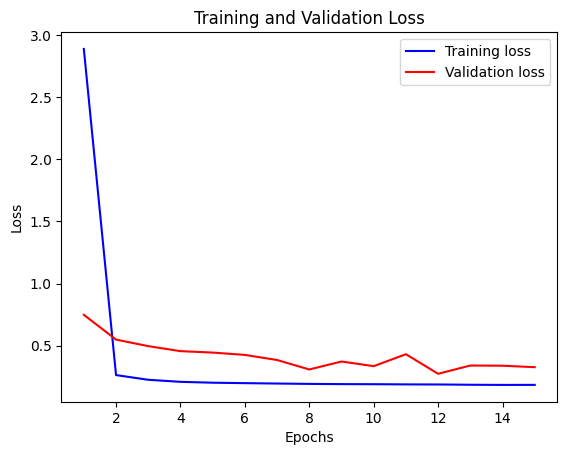

In [187]:
# Extract the loss values from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a plot of epochs vs. loss
epochs = range(1, len(train_loss) + 1)


plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [188]:
del X_test['week_num1']

In [189]:
preds = model.predict(X_test)

434/434 [==============================] - 1s 2ms/step


In [190]:

df = pd.DataFrame(preds)
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,2.771453,2.767316,2.765353,2.770166,2.768919,2.769697,2.768727,2.765719,2.770361,2.771621,2.766824,2.769648
1,2.812369,2.808277,2.805151,2.810654,2.809190,2.810250,2.808754,2.806034,2.811249,2.812669,2.807247,2.810320
2,2.850781,2.846775,2.845933,2.849711,2.848700,2.849411,2.848077,2.845978,2.849389,2.850441,2.847146,2.849556
3,2.899424,2.895031,2.894945,2.898457,2.897531,2.898086,2.896792,2.894637,2.897856,2.898940,2.895914,2.898266
4,2.760930,2.757426,2.754422,2.759464,2.758122,2.759139,2.757933,2.755314,2.760037,2.761241,2.756300,2.759116
...,...,...,...,...,...,...,...,...,...,...,...,...
13855,2.916487,2.915157,2.914389,2.915670,2.914928,2.916552,2.912789,2.915228,2.914647,2.914690,2.916306,2.917531
13856,2.773905,2.774621,2.771636,2.772788,2.771890,2.774360,2.769405,2.773860,2.772302,2.771871,2.774618,2.775596
13857,3.125774,3.119998,3.123019,3.124991,3.124518,3.124582,3.122720,3.121499,3.123162,3.124282,3.123275,3.125157
13858,2.314787,2.311196,2.301158,2.311966,2.309383,2.310790,2.311746,2.304268,2.315865,2.318175,2.304651,2.309600


In [191]:
final_prediction=np.round(np.expm1(preds))
submission['units_sold']=final_prediction

In [192]:
submission

,record_ID,units_sold
0,212645,15.0
1,212646,16.0
2,212647,16.0
3,212648,17.0
4,212649,15.0
...,...,...
13855,232281,17.0
13856,232282,15.0
13857,232285,22.0
13858,232286,9.0


In [193]:
submission.to_csv('sales_forecast_submission.csv', index=False)